In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Seminar 1 - Linear Regression

Javier González Otero - 243078

Jordi Guillén González - 253027

David Sánchez Maldonado - 253798

## Dataset features & labels

Features:
- Number of stations: number of stations in the network.
- Load (Mbps): Load of the network in Mbps.
- Size x (m): Size of the x axis in the network in metres.
- Size y (m): Size of the y axis in the network in metres.
- Area (m2): Area of the network in m2.
- Contention window: Maximum number to be chosen randomly when choosing the backoff value.
- Channel width (MHz): Range of frequencies at which the network can send data.
- Packet size (bits): Maximum data in bits that can be sent in a packet.
- Max RSSI (dbm): Maximum signal intensity received in dbm.
- Avg RSSI (dbm): Average signal intensity received in dbm.
- Min RSSI (dbm): Minimum signal intensity received in dbm.

Labels:
- Avg prob fail: Average probability of a packet not being sent correctly.
- Throughput (bps): Data correctly sent in bps (we will focus only on this label).
- Avg delay (s): Average transmission time of the packets in the network in seconds.
- Total airtime (s): Total transmission time summing all packets in seconds.
- Proportional airtime (s): Available transmission time used by the network in seconds.

## Part 1 - Data Preparation & EDA

### Data preparation and cleaning

In [ ]:
# Path to file containing data
file_path = "data/dataset_Seminar1.txt"

# Column names
column_names = [
    "num_STAs", "load_Mbps", "size_x_m", "size_y_m", "area_m2",
    "cw_slots", "channel_width_MHz", "packet_size_bits",
    "max_RSSI_dBm", "avg_RSSI_dBm", "min_RSSI_dBm",
    "avg_prob_failure", "throughput_bps", "avg_delay_s",
    "total_airtime_s", "prop_airtime"
]

# Load data into a pandas dataframe
dataframe = pd.read_csv(file_path, sep=r'\s+', header=None, names=column_names)

# Drop unwanted columns
columns_to_drop = ["avg_prob_failure", "avg_delay_s", "total_airtime_s", "prop_airtime"]
dataframe = dataframe.drop(columns=columns_to_drop)

In [ ]:
# Check for missing, NaNs, or non valid values
def check_missing_values(df):
    return pd.DataFrame({
        "null_or_nan": df.isnull().sum(),
        "empty_strings": (df.astype(str).apply(lambda x: x.str.strip()) == '').sum(),
        "total_missing": df.map(lambda x: pd.isnull(x) or (isinstance(x, str) and x.strip() == "")).sum()
    })

check_missing_values(dataframe)

,null_or_nan,empty_strings,total_missing
num_STAs,0,0,0
load_Mbps,0,0,0
size_x_m,0,0,0
size_y_m,0,0,0
area_m2,0,0,0
cw_slots,0,0,0
channel_width_MHz,0,0,0
packet_size_bits,0,0,0
max_RSSI_dBm,0,0,0
avg_RSSI_dBm,0,0,0


No cleaning needed, there are no missing values nor Null ones, neither empty strings.

In [ ]:
dataframe.head()

,num_STAs,load_Mbps,size_x_m,size_y_m,area_m2,cw_slots,channel_width_MHz,packet_size_bits,max_RSSI_dBm,avg_RSSI_dBm,min_RSSI_dBm,throughput_bps
0,40.0,60000000.0,22.0,39.0,858.0,63.0,80.0,4000.0,-42.928330,-63.163012,-74.965338,7.208644e+06
1,35.0,52500000.0,20.0,33.0,660.0,31.0,40.0,10000.0,-47.815800,-63.298410,-72.847989,1.545116e+07
2,16.0,12000000.0,34.0,14.0,476.0,255.0,40.0,4000.0,-46.138494,-60.076333,-70.044800,6.743660e+06
3,37.0,18500000.0,35.0,7.0,245.0,31.0,80.0,10000.0,-42.708813,-60.141393,-72.029643,1.675025e+07
4,18.0,4500000.0,36.0,35.0,1260.0,127.0,160.0,8000.0,-45.492991,-63.780783,-76.225550,4.500000e+06


### Data statistics

In [ ]:
dataframe.describe()

,num_STAs,load_Mbps,size_x_m,size_y_m,area_m2,cw_slots,channel_width_MHz,packet_size_bits,max_RSSI_dBm,avg_RSSI_dBm,min_RSSI_dBm,throughput_bps
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,21.446170,2.140292e+07,20.562940,20.479640,421.270350,227.043920,75.106000,7997.580000,-45.911165,-57.577426,-66.467827,9.716009e+06
std,11.554365,1.852042e+07,11.545206,11.540626,360.344349,323.350855,53.704279,2825.532513,5.400265,6.108548,8.057528,4.958025e+06
min,2.000000,5.000000e+05,1.000000,1.000000,1.000000,3.000000,20.000000,4000.000000,-81.405165,-81.405165,-84.333834,5.000000e+05
25%,11.000000,7.250000e+06,11.000000,11.000000,120.000000,15.000000,20.000000,6000.000000,-48.131476,-61.985000,-72.637078,6.187692e+06
50%,21.000000,1.600000e+07,21.000000,20.000000,320.000000,63.000000,80.000000,8000.000000,-44.111064,-58.163205,-67.997587,9.113764e+06
75%,31.000000,3.000000e+07,31.000000,30.000000,640.000000,255.000000,160.000000,10000.000000,-41.888821,-53.589525,-61.525848,1.343290e+07
max,41.000000,8.200000e+07,40.000000,40.000000,1600.000000,1023.000000,160.000000,12000.000000,-40.863587,-40.865960,-40.865960,2.262273e+07


### Separate continuous and discrete variables

In [ ]:
continuous_variables = ['num_STAs', 'load_Mbps', 'size_x_m', 'size_y_m', 'area_m2', 'max_RSSI_dBm', 'avg_RSSI_dBm', 'min_RSSI_dBm', 'throughput_bps']
discrete_variables = ['cw_slots', 'channel_width_MHz', 'packet_size_bits']

In [ ]:
stas = sorted(dataframe["num_STAs"].unique())
print(len(stas))

40


Considering that we will be doing a regression task, that it seems that it is well distributed (quantiles well located) and that there are 40 different values (big number) we will consider it as a continuous variable despite it is technically discrete

### Check the distribution of all variables without normalization

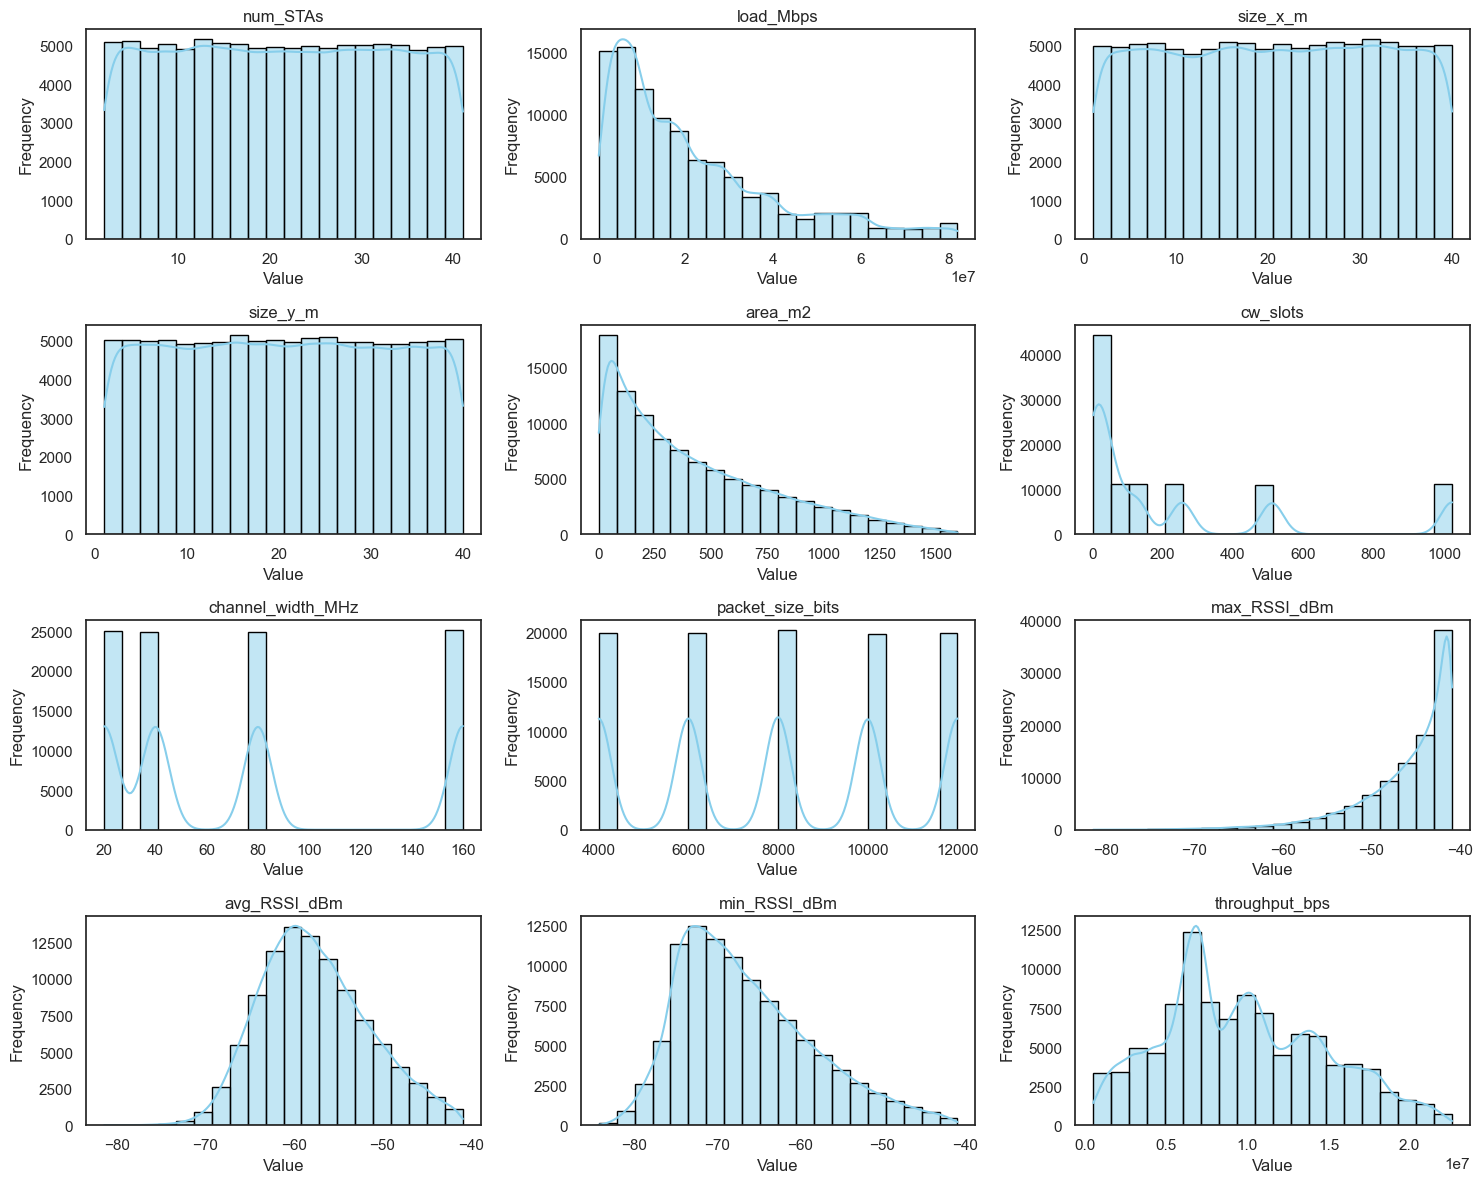

In [ ]:
# Columns to plot
columns_to_plot = dataframe.columns.tolist()

# Create figure and axes
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Plot histogram + KDE
for i, col in enumerate(columns_to_plot):
    sns.histplot(dataframe[col], bins=20, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused axes
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

max/min/avg RSSI may have a normal distribution, hence being suitable for linear models.

throughput could be a multimodal distribution, possibly leading to different clusters of data

### Normalize data to compare distributions

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to the entire DataFrame
standardized_data = scaler.fit_transform(dataframe)

# Convert the result back to a pandas DataFrame with the original column names
standardized_df = pd.DataFrame(standardized_data, columns=dataframe.columns)

### Compare density of continuous variables with target (throughput)

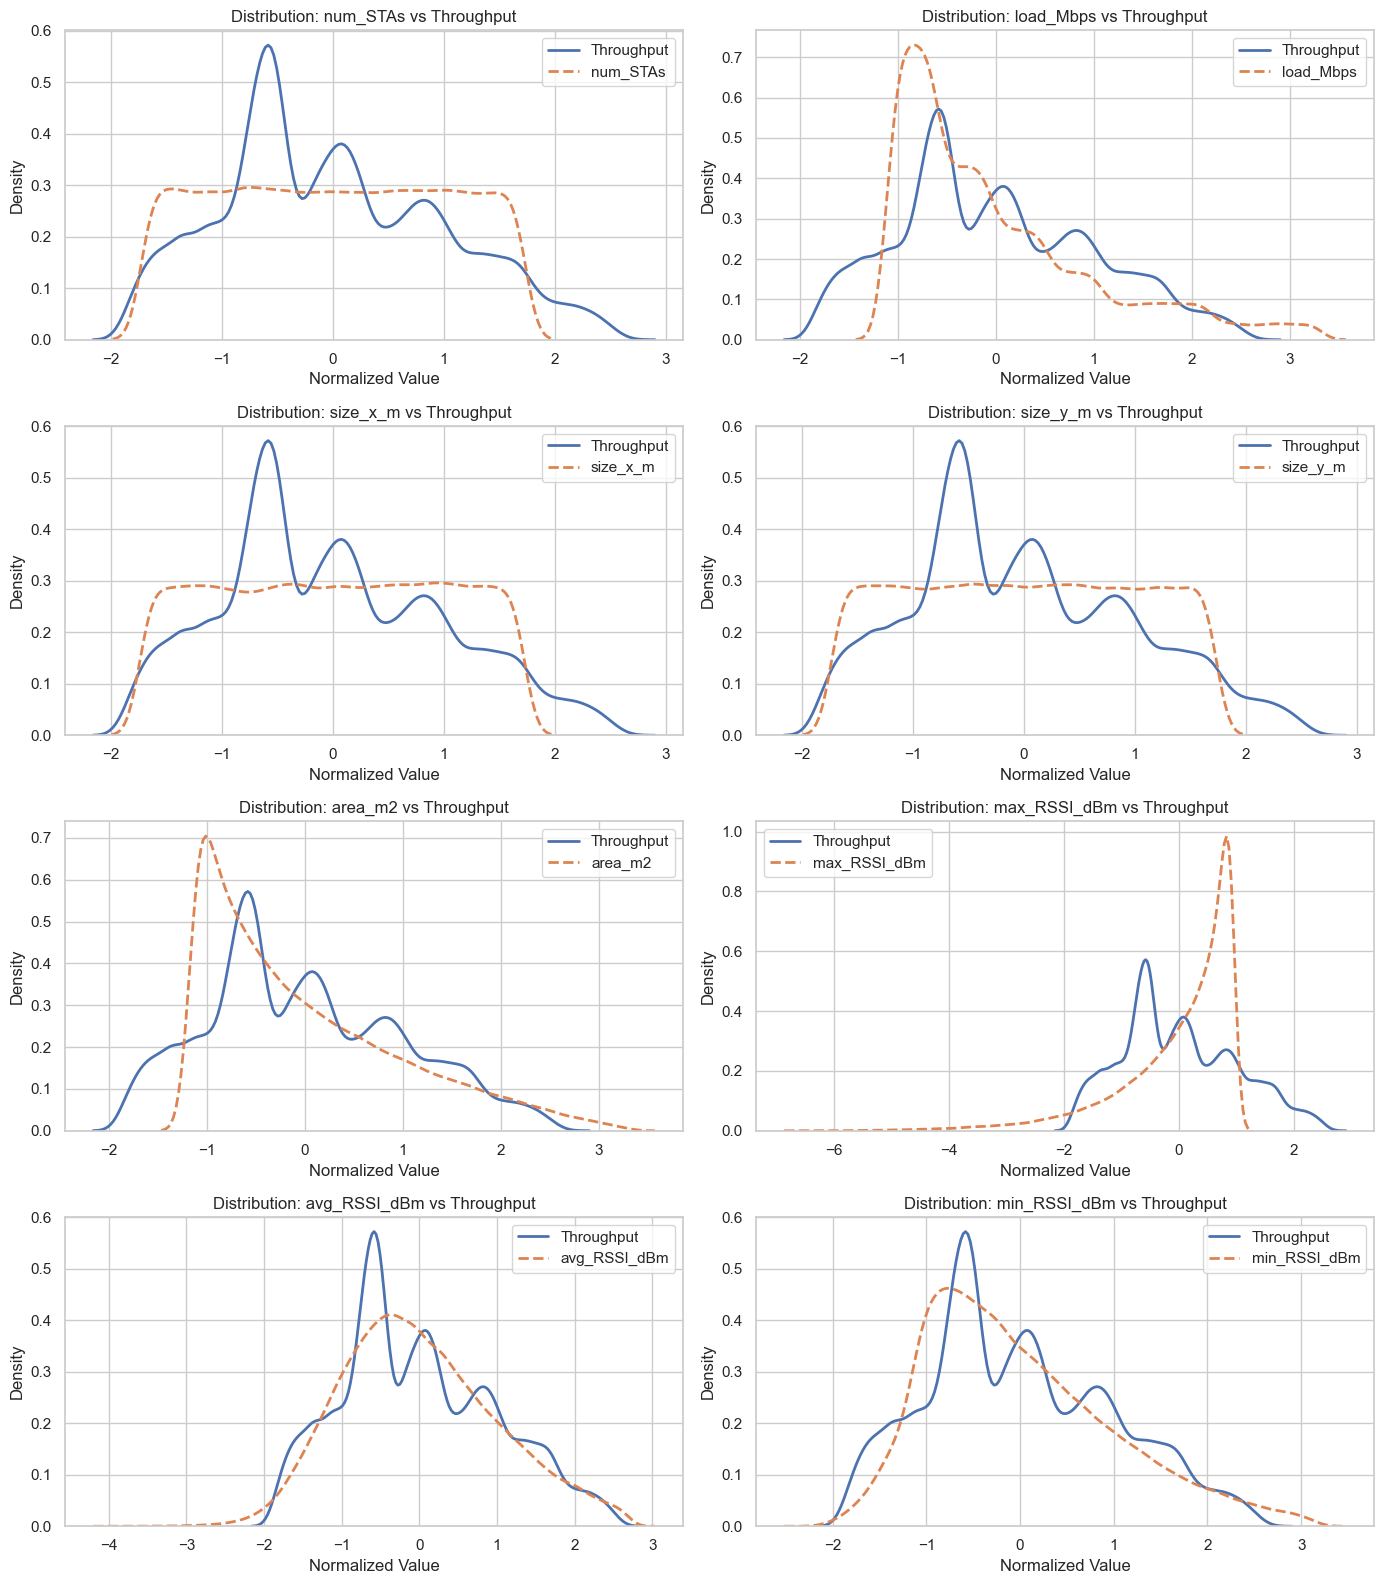

In [ ]:
# Set plot style for better aesthetics
sns.set(style="whitegrid")

# Create a 4x2 subplot grid (8 total)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Plot KDEs of each continuous variable compared to throughput
for i, variable in enumerate(continuous_variables[:-1]):
    ax = axes[i]

    # Plot throughput distribution (solid line)
    sns.kdeplot(data=standardized_df, x="throughput_bps", label="Throughput", ax=ax, linewidth=2)

    # Plot current variable distribution (dashed line)
    sns.kdeplot(data=standardized_df, x=variable, label=variable, ax=ax, linestyle="--", linewidth=2)

    # Titles and labels
    ax.set_title(f'Distribution: {variable} vs Throughput', fontsize=12)
    ax.set_xlabel("Normalized Value")
    ax.set_ylabel("Density")
    ax.legend()

# Remove any unused subplots
if len(continuous_variables) < len(axes):
    for j in range(len(continuous_variables), len(axes)):
        fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

By comparing the normalized distributions of the continuous variables with the target variable throughput_bps, we observe that some features like avg_RSSI_dBm, min_RSSI_dBm, area and load Mbps have similar shapes, suggesting a potential relationship. Others, such as max_RSSI_dBm, size_x, size_y and num_STAs, show different patterns, indicating weaker or more complex associations. This visual analysis is helpful for initial exploration but should be supported by quantitative methods such as a correlation matrix to confirm relevance.

### Compare distribution of throughput fixing different values of discrete variables

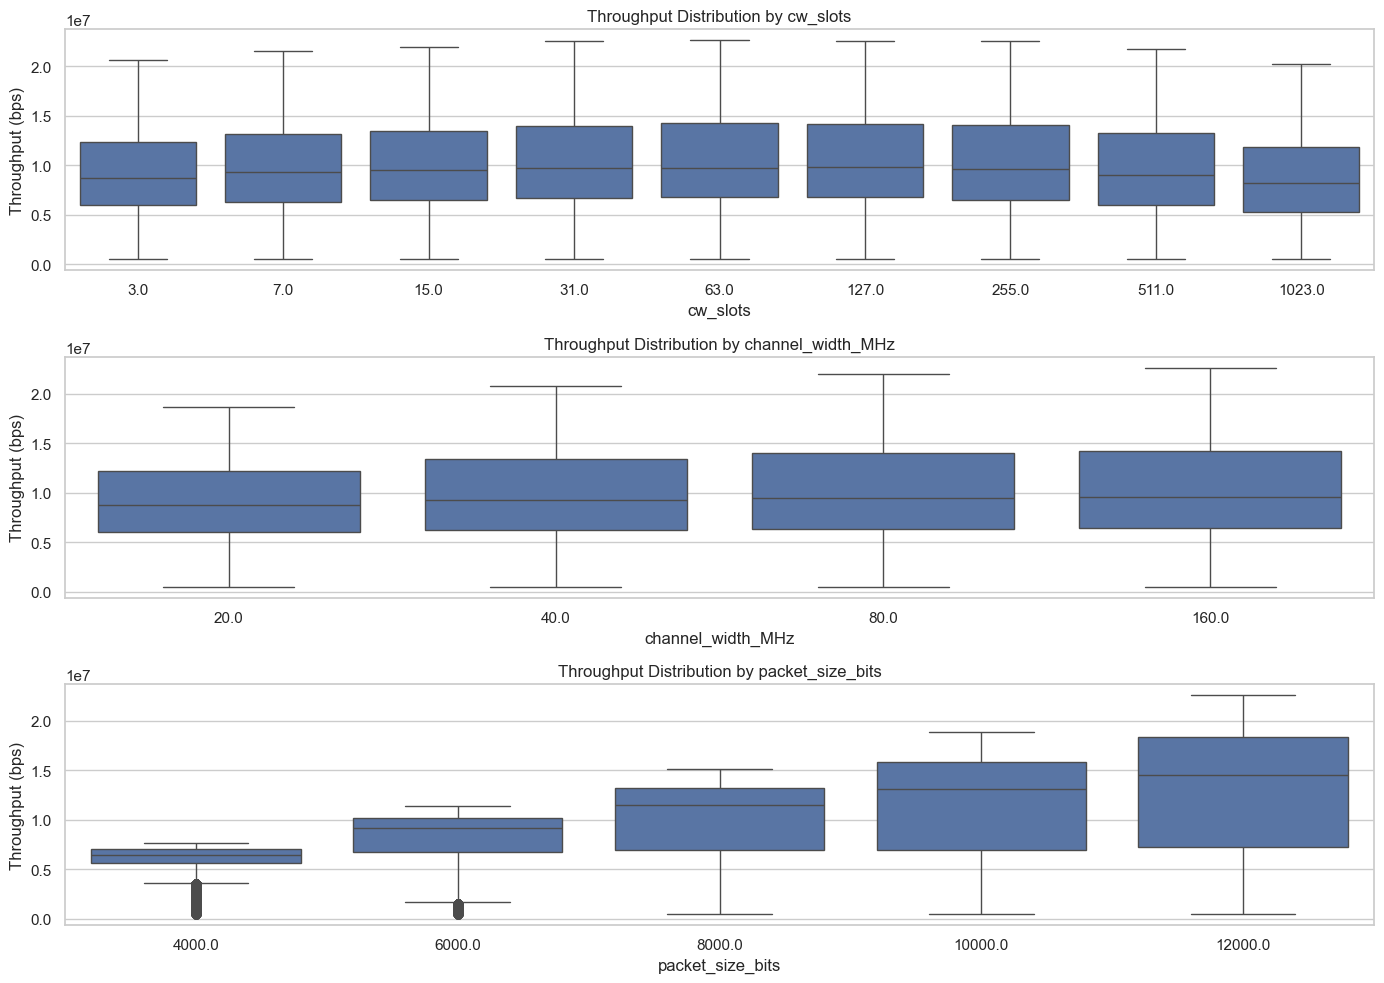

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# List of discrete variables
discrete_variables = ["cw_slots", "channel_width_MHz", "packet_size_bits"]

# Create one plot per discrete variable
fig, axes = plt.subplots(nrows=len(discrete_variables), figsize=(14, 10), sharey=True)

for i, var in enumerate(discrete_variables):
    ax = axes[i]

    sns.boxplot(data=dataframe, x=var, y="throughput_bps", ax=ax)

    ax.set_title(f"Throughput Distribution by {var}", fontsize=12)
    ax.set_xlabel(var)
    ax.set_ylabel("Throughput (bps)")

plt.tight_layout()
plt.show()

By comparing the distribution of throughput across different values of the discrete variables, it appears that contention window slots likely do not have a significant impact on the final throughput, suggesting it may be an uninformative feature., even it probably presents a nonlinear relationship with throughput, leading to distorsions in model coefficients. In contrast, channel width shows a clear positive correlation with throughput, which makes sense as wider channels allow for higher data transmission rates. Similarly, packet size is positively correlated with throughput, which is expected because larger packets reduce overhead and improve transmission efficiency.

### Correlation heatmap

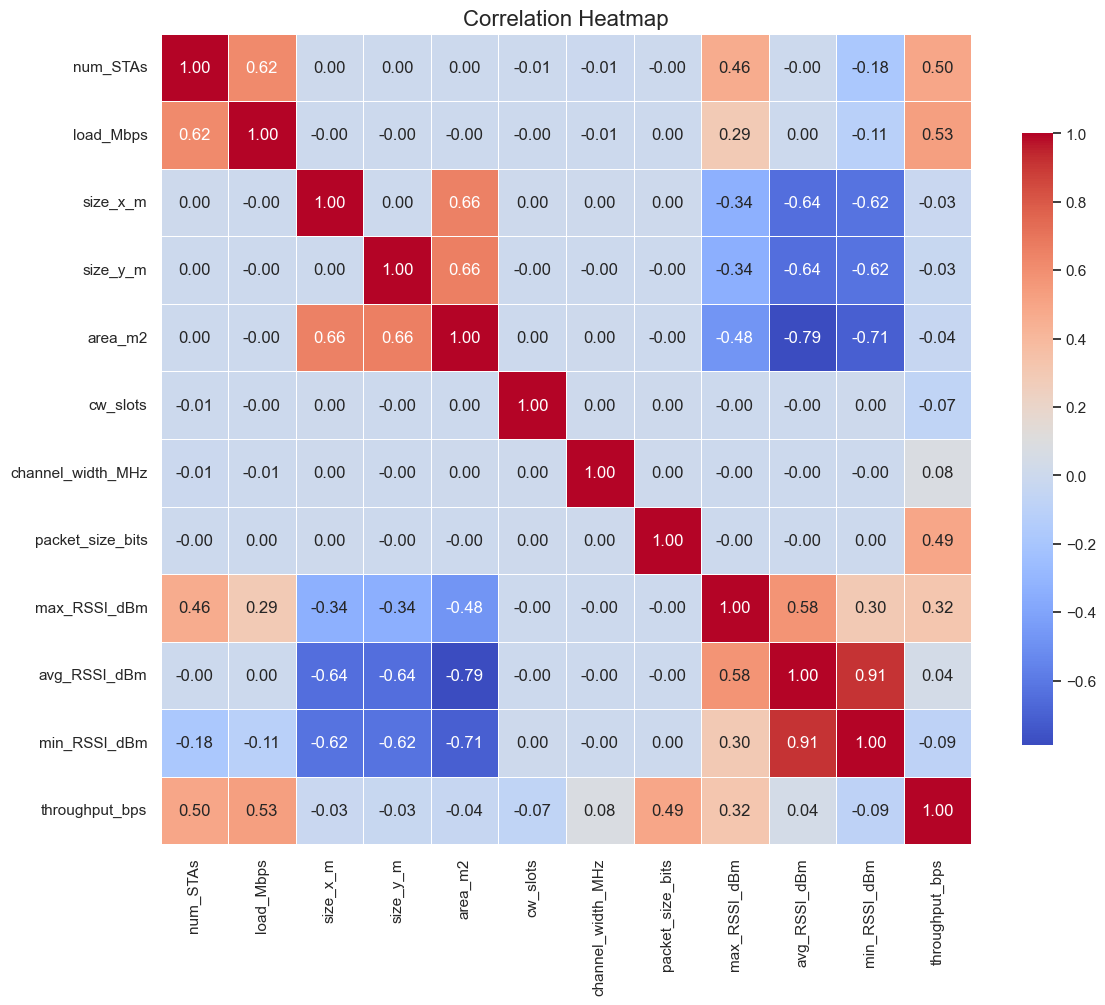

In [ ]:
# Calculate correlation matrix
correlation_matrix = standardized_df.corr(numeric_only=True)

# Set plot size and style
plt.figure(figsize=(12, 10))
sns.set(style="white")

# Create heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,         # show correlation values
    fmt=".2f",          # format to 2 decimal places
    cmap="coolwarm",    # color map
    square=True,        # square cells
    linewidths=0.5,     # line between boxes
    cbar_kws={"shrink": .75}
)

plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

The correlation heatmap shows that load_Mbps, num_STAs, and packet_size_bits are the most positively correlated features with throughput_bps, with correlation values around 0.5. This suggests that as the network load, number of connected stations, and packet size increase, the overall throughput tends to increase as well. On the other hand, RSSI-related features such as avg_RSSI_dBm, min_RSSI_dBm, and area_m2 are negatively correlated with throughput, reflecting the fact that weaker signal strengths and larger areas are typically associated with lower throughput. Variables such as cw_slots and channel_width_MHz show near-zero correlation, indicating limited or no linear relationship with throughput in this dataset.

### Colinearity among features

In the correlation heatmap we can clearly visualize some colinearities that may distort the coefficients of the model

* load Mbps - num STAs: correlation of 0.62 indicating that it is probably not necessary to include both variables. **We will only use load Mbps** since it is strongly correlated with throughput

* size x/y - area: obiously the size of the sides of the space are correlated with the area, hence **we will only consider area** variable for the linear regression

* RSSI: to perform a linear regression it is not necessary to include all three variables, since they represent the same. **We will only use max RSSI** which seems to have a stronger correlation with throughput.

### Discard unnecesary variables

In [ ]:
discard_variables = [
        # Dropped due to high correlation with load_Mbps
    "size_x_m",          # Dropped due to high correlation with area_m2
    "size_y_m",          # Dropped due to high correlation with area_m2
    "min_RSSI_dBm"       # Dropped due to high correlation with max_RSSI_dBm
]

# Discard selected variables
regression_df = standardized_df.drop(columns=discard_variables)

### Split the data to be used in a ML model

In [ ]:
# Define X (features) and y (target)
X = regression_df.drop(columns=["throughput_bps"])
y = regression_df["throughput_bps"]

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% test, 80% train
    random_state=42,      # for reproducibility
    shuffle=True
)

## Part 2: Model implementation

### Model creation and fitting

In [ ]:
# Create the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict on both train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Compute error metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")

Train MSE: 0.41
Test MSE: 0.42
Test R² Score: 0.5865


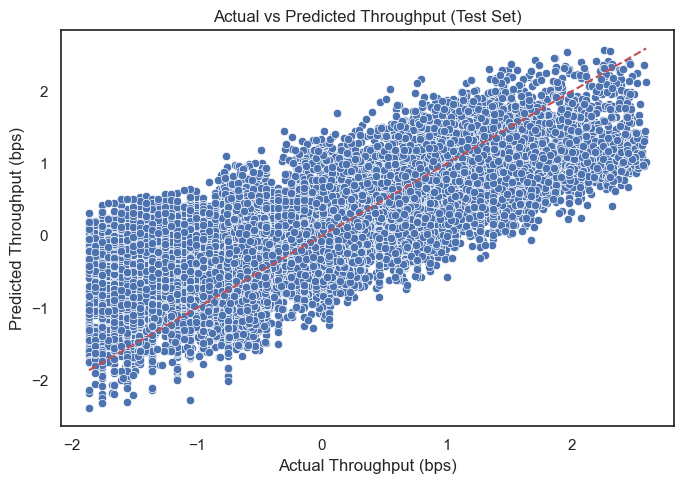

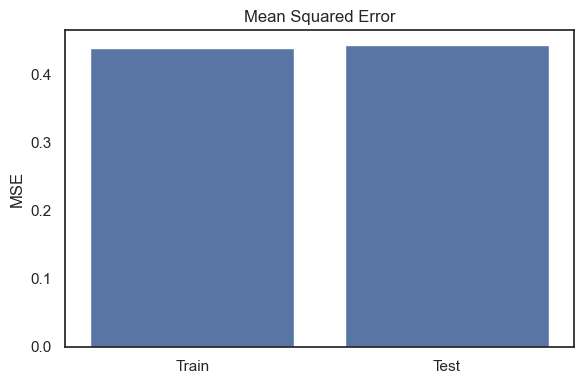

In [ ]:
# Scatter plot: Real vs Predicted
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual Throughput (bps)")
plt.ylabel("Predicted Throughput (bps)")
plt.title("Actual vs Predicted Throughput (Test Set)")
plt.tight_layout()
plt.show()

# Bar plot of MSE
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train", "Test"], y=[train_mse, test_mse])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()